<a href="https://colab.research.google.com/github/cyankaet/orderml/blob/master/orderparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/orderml

/content/drive/My Drive/orderml


Any other drive folder is, hint, probably not the correct one! Navigate to where your orderml folder is in your drive. This code should work for a top-level folder.

Check you're in the right folder. ("ls test")


In [ ]:
ls

logs/  orderparams.ipynb  problems.txt  __pycache__/  test.png


Install non-default packages here.

In [ ]:
!pip install bumps
!pip install gym
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

     |████████████████████████████████| 522kB 3.4MB/s 
  Created wheel for bumps: filename=bumps-0.7.16-cp36-none-any.whl size=546174 sha256=b8a0378149c7994aac97dd66c920c6a67ea6d41502bb1a8aafa94f13ec892a49
  Stored in directory: /root/.cache/pip/wheels/41/f7/17/a898c85754ad1c6d7de087e28809af7989b81f14f200547de3
Successfully built bumps
TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 3.1MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


"Compile" code.

In [ ]:
class OrderMethods():

    def getData(T, x, p):
        Jt, Nf, Bk = p
        return OrderMethods.orderparameter(T, x, Jt, Nf, Bk)

    def bsol(temp,p):
        Tn,Jt,Nf,Bk=p
        t=4.0*(Jt/(Jt+1.0))*Tn/temp
        #print t
        if (Tn<=0) or (Jt<=0) or temp>=Tn:
            xout=0.0
        else:
            xout=optimize.brentq(OrderMethods.bfun,0.0,t,args=(temp,p),xtol=1e-6)

        return xout


    def bfun(x,T,p):
        Tn,Jt,Nf,Bk=p
        if x==0.0:
            B=-1.0 # so that it wont find solution at zero
        else:
            B=(x-3*OrderMethods.brill(Jt,x)*(Jt/(Jt+1))*(Tn/T))
        return B

    def brill(j,x):
        temp=(2*j+1.0)/2/j
        if x==0:
            Br=0.0
        else:
            Br=temp/np.tanh(temp*x)-1.0/np.tanh(x/2/j)/2/j
        return Br

    def Intensity(T,p):
        Tn,Jt,Nf,Bk=p
        br=OrderMethods.brill(Jt,OrderMethods.bsol(T,p))
        bout=Bk+Nf*br**2
        return bout

    def orderparameter(T, Tn, Jt, Nf, Bk):
        p=[Tn, Jt, Nf, Bk]
        I=[]
        for t in T:
            I.append(OrderMethods.Intensity(t,p))
        return np.array(I)

    def fit(model):
        problem = FitProblem(model)
        result = fitters.fit(problem, method='lm')
        for p, v in zip(problem._parameters, result.dx):
            p.dx = v
        return result.x, result.dx, problem.chisq(), problem._parameters
        

Execute main class.

In [ ]:
import sys
import numpy as np
import pylab as plt
import scipy.optimize as optimize
from bumps.names import *
import bumps.fitters as fitters
import gym.spaces as spaces
import gym

class OrderEnv(gym.Env): #add gym.env

    def __init__(self):
        self.reward_scale = 100
        self.episodeNum = 0
        self.steps = 0
        self.T = np.array([])
        self.startTn = 160
        self.p = [.885,330,.3]
        self.error = []
        # self.M = Curve(orderparameter, T, I, error, Jt = self.p[0], Nf = self.p[1], Bk = self.p[2])
        # self.M.Tn.range(self.startTn - 20 , self.startTn + 20)

        self.observation_space = spaces.Box(low = np.array([3]), high = np.array([340]))
        #self.action_space = spaces.Box(0, 337)
        self.curTemp = 3
        self.x = self.startTn

        #logging arrays and vars
        self.rewards = [] #interepisodic
        self.chisqds = []
        self.transTemps = []
        self.totReward = 0 
        self.info = {}     

    def step(self, action): 

        print("stepping")

        self.curTemp += action
        print("curtemp: ", self.curTemp)
        self.curTemp = self.round_to(self.curTemp, 0.5)

        self.steps += 1
        reward = -self.reward_scale
        self.T = np.append(self.T, self.curTemp)
        print("Temperature: ", self.T)
        
        if self.steps > 1:
            self.I = OrderMethods.getData(self.T, self.x, self.p)
            print("Intensity: ", self.I)
            self.error= np.sqrt(self.I)
            M = Curve(OrderMethods.orderparameter, self.T, self.I, self.error, Jt = self.p[0], Nf = self.p[1], Bk = self.p[2])
            M.Tn.range(self.x - 20 , self.x + 20)

            self.x, dx, chisq, params = OrderMethods.fit(M)
            self.x = self.x[0]

            dx = params[0].dx

            reward = 0

            if chisq < 10:
                reward += 1000

                if dx < 2e-3:
                    reward+=1/dx

            self.chisqds.append(chisq)
            self.transTemps.append(self.x)

        self.totReward += reward
        self.state = np.array([self.curTemp])

        if (self.steps > 10 and chisq < 0.05):
            terminal = True
            self.log()
        if (self.steps > 30):
            terminal = True
            self.log()
        else:
            terminal = False

        return self.state, reward, terminal, self.info


    def reset(self):
        print("reset")
        self.steps = 0
        self.T = np.array([])
        self.I = []
        self.chisqds = []
        self.transTemps = []
        self.totReward = 0
        self.curTemp = 3
        self.state = np.array([3])

        return self.state #starting state

    def log(self):
        self.episodeNum += 1

        filename = "logs/chis/chiLog-" + str(self.episodeNum) + ".txt"
        np.savetxt(filename, self.chisqds)

        filename = "logs/temps/tnLog-" + str(self.episodeNum) + ".txt"
        np.savetxt(filename, self.transTemps)

        self.rewards.append(self.totReward)
        filename = "logs/runrewards.txt"
        np.savetxt(filename, self.rewards)

    @property
    def action_space(self):
        return spaces.Box(low = np.array([0]), high = np.array([340 - self.curTemp]))

    def round_to(self, n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision


In [ ]:
from stable_baselines.common.env_checker import check_env
env = OrderEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

reset
stepping
curtemp:  [7.0680294]
Temperature:  [7.]
stepping
curtemp:  [229.58272]
Temperature:  [  7.  229.5]
Intensity:  [3.303e+02 3.000e-01]
stepping
curtemp:  [320.54926]
Temperature:  [  7.  229.5 320.5]
Intensity:  [3.303e+02 3.000e-01 3.000e-01]
stepping
curtemp:  [331.88116]
Temperature:  [  7.  229.5 320.5 332. ]
Intensity:  [3.303e+02 3.000e-01 3.000e-01 3.000e-01]
stepping
curtemp:  [335.00302]
Temperature:  [  7.  229.5 320.5 332.  335. ]
Intensity:  [3.303e+02 3.000e-01 3.000e-01 3.000e-01 3.000e-01]
stepping
curtemp:  [339.3101]
Temperature:  [  7.  229.5 320.5 332.  335.  339.5]
Intensity:  [3.303e+02 3.000e-01 3.000e-01 3.000e-01 3.000e-01 3.000e-01]
stepping
curtemp:  [339.92264]
Temperature:  [  7.  229.5 320.5 332.  335.  339.5 340. ]
Intensity:  [3.303e+02 3.000e-01 3.000e-01 3.000e-01 3.000e-01 3.000e-01 3.000e-01]
stepping
curtemp:  [340.]
Temperature:  [  7.  229.5 320.5 332.  335.  339.5 340.  340. ]
Intensity:  [3.303e+02 3.000e-01 3.000e-01 3.000e-01 3.00

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/stable_baselines/common/env_checker.py:210: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn("We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


temperature:  [ 50 100 150 200 250]
Intensity:  [3.25537076e+02 2.48661702e+02 5.41124126e+01 3.00000000e-01
 3.00000000e-01]


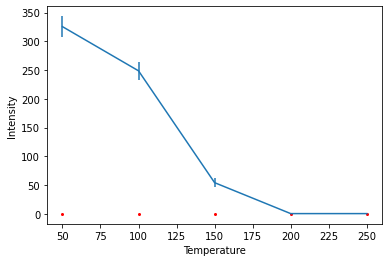

In [ ]:
p=[.885,330,.3]
T=np.arange(50, 300, 50)
print("temperature: ", T)
#T=N.arange(10,300,2)
I=[]
error = []

I=OrderMethods.orderparameter(T, 160,p[0],p[1],p[2])
print("Intensity: ", I)
error= np.sqrt(I)
#print(error)

M = Curve(OrderMethods.orderparameter, T, I, error, Jt = p[0], Nf = p[1], Bk = p[2])
M.Tn.range(10,400)

x, dx, chisq, params = OrderMethods.fit(M)
#print(x)

fitI = OrderMethods.orderparameter(T, x, p[0],p[1],p[2])

plt.errorbar(T, I, error)
plt.plot(T, fitI,'ro', markersize = 2)
plt.xlabel("Temperature")
plt.ylabel("Intensity") 
plt.show()
plt.savefig("test")
plt.close()

In [20]:
from stable_baselines import DQN, PPO2, A2C, ACKTR
from stable_baselines.common.cmd_util import make_vec_env

# Instantiate the env
env = OrderEnv()
# wrap it
env = make_vec_env(lambda: env, n_envs=1)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# Train the agent
model = A2C('MlpPolicy', env, verbose=1).learn(5000)

Streaming output truncated to the last 5000 lines.
curtemp:  [13.]
Temperature:  [ 3.5  3.5  3.5  3.5  3.5  3.5  3.5  4.5  5.   5.5  5.5  5.5  5.5  5.5
  5.5  5.5  6.5  6.5  6.5  7.   7.   8.   9.   9.   9.5  9.5 11.5 11.5
 12.5 13.  13. ]
Intensity:  [330.3        330.3        330.3        330.3        330.3
 330.3        330.3        330.29999999 330.29999993 330.29999942
 330.29999942 330.29999942 330.29999942 330.29999942 330.29999942
 330.29999942 330.29998539 330.29998539 330.29998539 330.29994809
 330.29994809 330.2995927  330.29797797 330.29797797 330.29602998
 330.29602998 330.26717726 330.26717726 330.22672675 330.19546128
 330.19546128]
reset
stepping
curtemp:  [3.7493286]
Temperature:  [3.5]
stepping
curtemp:  [3.895105]
Temperature:  [3.5 4. ]
Intensity:  [330.3 330.3]
stepping
curtemp:  [4.1086354]
Temperature:  [3.5 4.  4. ]
Intensity:  [330.3 330.3 330.3]
stepping
curtemp:  [4.232283]
Temperature:  [3.5 4.  4.  4. ]
Intensity:  [330.3 330.3 330.3 330.3]
stepping
curtemp

In [ ]:
# Test the trained agent
obs = env.reset()
n_steps = 20
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render(mode='console')
  if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print("Goal reached!", "reward=", reward)
    break